In [1]:
import numpy as np
import emcee as em
import pandas as pd
import matplotlib.pyplot as plt

### Boxfit

To import the input parameters, and keep them for the rest of the code, and get the output values of BoxFit

In [2]:
# Importing the files from BOXFIT
# Change the path here according to the output directory of BoxFit 
settings = '/home/agath/boxfitoutput/boxfitsettings.txt'
lightcurve_box = '/home/agath/boxfitoutput/lightcurve.txt'
spectrum_box = '/home/agath/boxfitoutput/spectrum.txt'

In [3]:
# Function to read the parameters from boxfitsettings 
def read_boxfit(settings): 
    B = {} # Declare an empty dictionary
    with open(settings,'r') as f:
        for line in f:
            # Check if line is not an overall comment, has an equal and a comment to describe the parameter
            if not line.strip().startswith('!') and '=' in line and '!' in line: 
                keyval_extra = line.strip().split('!')                  #Split the key + value from the comment using the !
                key_value = keyval_extra[0].split('=')                  #Split the key from the value using the = 
                key, value = key_value[0].strip(), key_value[1].strip() #Store them
                
                #If the value is a number, store it in B, and convert it from a string to a float
                if value.isdigit() or 'e-' in value or 'e' in value or '.' in value:
                    #Additionnal condition because simplex and grbdata could get past this point
                    if not '.txt' in value: 
                        B[key] = float(value) 
    return B

In [4]:
B = read_boxfit(settings)

In [5]:
#Boundaries for the time and the frequencies 
t_min = B['t_0']
t_max = B['t_1'] 

nu_min = B['nu_0']
nu_max = B['nu_1']

points = int(B['no_points'])

In [6]:
#The corresponding linspaces
tl = np.geomspace(t_min, t_max, points)
nus = np.geomspace(nu_min, nu_max, points)

nul = np.ones(nus.shape)*nu_min
ts = np.ones(tl.shape)*t_min

In [7]:
#Initialize the lists for Boxfit
tbox =  []
nubox =  []
Flbox =  []
Fnubox =  []

def read_data_box(f, lightcurve = True): #lightcurve = true when getting the lightcurve data, lightcurve = false for the spectrum
    #Dummy index
    i = 0

    #Loop on the line
    for line in f:

        #Ignore line if it's a comment
        if line.startswith('#'):
            i = i + 1
            continue  # The loop restarts
    
        #Split line into columns and remove the commas
        columns = line.strip().replace(',','').split()  

        #Add data to lists        
        if lightcurve == True:
            tbox.append(float(columns[1]))
            Flbox.append(float(columns[3]))
        else:
            nubox.append(float(columns[2]))
            Fnubox.append(float(columns[3]))
            
        

# To read the data from Boxfit and plot it 
with open(lightcurve_box, 'r') as f1, open(spectrum_box, 'r') as f2:
    read_data_box(f1, lightcurve=True)  #Getting the lightcurve
    read_data_box(f2,lightcurve=False)  #Getting the spectrum

# Convert lists to arrays
tbox = np.array(tbox)       #Just here to make sure it's the same as the linspace tl
nubox = np.array(nubox)     #Same for nus
Fnubox = np.array(Fnubox)
Flbox = np.array(Flbox)


Small useful functions 

In [8]:
#Converts E to Eiso
def convert_E_Eiso(E,theta):
    Eiso = E/(1-np.cos(theta))  #Theta being the half opening angle of the jet
    print(E, np.cos(theta))
    return Eiso 

In [9]:
#Converts Eiso to E
def convert_Eiso_E(Eiso,theta):
    E = Eiso*(1-np.cos(theta)) #Theta being the half opening angle of the jet
    return E 

In [10]:
print(convert_E_Eiso(2.5*10**50,0.07))

2.5e+50 0.9975510002532796
1.0208249320351635e+53


In [11]:
#Converts time in s to time in days
def convert_ts_td(t):
    return t/(60*60*24)

In [12]:
#Calculate the lorentz factor 
def calc_lf(eta_0, gamma_B):
    gamma = 2*eta_0*gamma_B
    return gamma

### Afterglowpy

In [13]:
import afterglowpy as grb

In [14]:
#Afterglowpy dictionary contining the specifics of the jet and environment parameters
A = {'jetType':     grb.jet.TopHat,     # Top-Hat jet
     'specType':    0,                  # Basic Synchrotron Spectrum
     'thetaWing':   2*B['theta_obs'],     # Outer truncation angle
     'thetaObs':    B['theta_obs'],     # Viewing angle in radians, (roughly 20 degrees)
     'E0':          1.0208249320351635e+53,             # Isotropic-equivalent energy in erg
     'thetaCore':   B['theta_0'],       # Half-opening angle in radians
     'n0':          B['n'],             # circumburst density in cm^{-3}
     'p':           B['p'],             # electron energy distribution index
     'epsilon_e':   B['epsilon_E'],     # epsilon_e
     'epsilon_B':   B['epsilon_B'],     # epsilon_B
     'xi_N':        B['ksi_N'],         # Fraction of electrons accelerated
     'd_L':         B['d_L'],           # Luminosity distance in cm (40Mpc)
     'z':           B['z'],             # redshift
     'b':           4.5}                # power for power-law structure theta**(-b)



In [15]:
print(B['E'])

8.2e+53


In [16]:
def light_curve_afterglowpy(A):
    # Calculate the fluxes
    Fnula = grb.fluxDensity(tl, nul, **A)   # For the lightcurve
    Fnusa = grb.fluxDensity(ts, nus, **A)   # For the spectrum

    return Fnula, Fnusa

Fnula, Fnusa = light_curve_afterglowpy(A)

In [17]:
#Get multiple geometries from Afterglowpy

#Here are all the types of jets and their names
types_jets = [grb.jet.TopHat, grb.jet.Gaussian, grb.jet.PowerLaw,  grb.jet.GaussianCore, grb.jet.PowerLawCore]
name_types_jets = ['TopHat', 'Gaussian', 'PowerLaw', 'GaussianCore','PowerLawCore']

#Make a loop over them and store the fluxes for each jet
afterglowpys = [light_curve_afterglowpy(A) for A['jetType'] in types_jets]

### DeepGlow

In [18]:
#Insert here the training code for DeepGlow

In [19]:
# #For DeepGlow
# model = Emulator(simtype='ism')

# abs_factor = (B['p'] - 2)/(B['p'] - 1)

# deep_array = [B['z'],           #redshift
#               np.log10(B['d_L']/10**28),    #luminosity distance (log10 of 10^28 cm)
#               np.log10(B['E']/10**53),    #isotropic-equivalent energy (log10 of 10^53 erg)
#               np.log10(B['n']),     #circumburst medium density (log10 of cm^-3)
#               B['theta_0'],    #jet half-opening angle (rad)
#               B['theta_obs']/B['theta_0'],   #off-axis observer angle as a fraction of the jet half-opening angle
#               B['p'],    #electron spectral index
#               np.log10(B['epsilon_E']*abs_factor),   # energy fraction in accelerated electrons (in log10), with factor of (p-2)/p-1 absorbed
#               np.log10(B['epsilon_B']),  #energy fraction in magnetic field (in log10)
#               np.log10(B['ksi_N'])  #fraction of electrons accelerated (in log10)
#               ]

# Fldeep = model.flux(params=deep_array, t_obs=tl, nu_obs=nul)


### JetFit

In [20]:
from FitterClass import *
from FluxGeneratorClass import *
from collections import defaultdict

In [21]:
#Importing the precomputed fluxes to put in the JetFit functions
Table = "./Table.h5"

In [22]:
#Function that removes the logscales
def Log2Linear(Log, Info):
    Linear = {} #Defined as a dictionary
    for i, key in enumerate(Info['Fit']):   #Going through all the parameters
        if key in Info['Log']:              #If it is in logscale, then use the exponential or 10^X
            if Info['LogType'] == 'Log10':
                Linear[key] = np.power(10.,Log[key])
            else:
                Linear[key] = np.exp(Log[key])
        else:
            Linear[key] = Log[key]
    # print(Linear['E'],Linear) #Debug statement to see the full dict
    return Linear


In [23]:
#Calculates the range for time with respect to the bounds of tau for jetfit

def range_time_tau():
    #The range and formula from the paper
    tau_min = 8.64e2
    tau_max = 8.64e7
    scale = (1. + J['z'])*(J['E']/J['n'])**(1./3.)
    ti = tau_min*scale
    tf = tau_max*scale

    print('The time range allowed by tau is: [',"{:e}".format(ti),',',"{:e}".format(tf),']')

    if t_min < ti:
        print('The lower boundary is out of bounds:', "{:e}".format(t_min), 'is lower than', "{:e}".format(ti))
    elif t_max > tf:
        print('The upper boundary is out of bounds:', "{:e}".format(t_max),'is higher than', "{:e}".format(tf))
    else:
        print('The values are within the time range.')
    return ti, tf

In [24]:
def light_curve_jetfit(P):
    #Call to the function to know if we are in the domain of validity of JetFit
    ti, tf = range_time_tau()
    
    #Calculate flux
    flux_jet = np.asarray(FluxGenerator.GetSpectral(tl, nul, P))

    return flux_jet

In [25]:
def get_integrated_jetfit(P):

    #The function takes as an input an array with two columns, so we split the data into two arrays with points (because points/2 fails)
    mid_point = nus[int(points/2)]
    nus_col = np.column_stack((np.geomspace(nu_min, mid_point, points), np.geomspace(mid_point, nu_max, points)))
    
    #Calculate flux
    Fsjet = np.asarray(FluxGenerator.GetIntegratedFlux(ts, nus_col, P))

    return nus_col, Fsjet

In [26]:
#JetFit informations
Info = {
    'Fit': np.array(['E', 'Eta0', 'GammaB','theta_obs','epsb','epse','n','p','z','xiN','dL','theta_obs']),  # Fitting parameters (Parameter names see P dictionary below)
    'Log': np.array([]),                                                                                    # Set parameters in log scale 'E','n','epse','epsb' (mesured in log for mcmc analysis)
    'LogType': 'Log10',                                                                                     # Log scale type: Log10 or Log
    'ThetaObsPrior': 'Sine',                                                                                # Prior for observation angle: Sine or Uniform
    'FluxType': 'Spectral'                                                                                  # Flux type: Spectral or Integrated
}

#JetFit bounds for parameters in linear scale
FitBound = {
    'E': np.array([1e-6, 1e3]),         
    'n': np.array([1e-6, 1e3]),
    'Eta0': np.array([2.,10.]),
    'GammaB': np.array([1.,12.]),
    'theta_obs': np.array([0.,1.]),
    'epse': np.array([1e-6,1.]),
    'epsb': np.array([1e-6,1.]),
    'p': np.array([2.,4.])
}

#JetFit dict
Explore = False # For non-fiting parameters, P set default values. 

J = {
    'E': 2.5,    # E0/10^50, need to convert because B takes Eiso as an input convert_Eiso_E(B['E'],B['theta_0'])/10**50
    'Eta0': 8,                                          #8
    'GammaB': 12,                                       #12
    'dL': B['d_L']/10**28,                              # dl/10^28 cm
    'epsb': B['epsilon_B'],
    'epse': B['epsilon_E'],
    'n': B['n'],                                        # has no unit because cm^{-3}/1cm^{-3}
    'p': B['p'],
    'theta_obs': B['theta_obs'],                        # This is the half opening angle
    'xiN': B['ksi_N'],
    'z': B['z']
}

#Transform the log variables from the P dictionnary to linear ones
J = Log2Linear(J,Info) 

#Create FluxGeneratorClass based on the given table
FluxGenerator = FluxGeneratorClass(Table)

#Get the lightcurve from the function
Fljet = light_curve_jetfit(J)

#Get the integrated lightcurve from the function
nusj, Fsjet = get_integrated_jetfit(J)

The time range allowed by tau is: [ 5.495818e+03 , 5.495818e+08 ]
The values are within the time range.


### JetSimpy

In [27]:
import jetsimpy

In [28]:
JS = dict(
    Eiso = 1.0208249320351635e+53,                          # (Jet) Isotropic equivalent energy
    lf = calc_lf(J['Eta0'], J['GammaB']),   # (Jet) Lorentz factor
    theta_c = B['theta_0'],                 # (Jet) half opening angle
    n0 = B['n'],                            # (ISM) constant number density
    k = 0,                                  # (ISM) wind power index
    A = 0,                                  # (ISM) wind amplitude
    eps_e = B['epsilon_E'],                 # (Radiation) epsilon_e
    eps_b = B['epsilon_B'],                 # (Radiation) epsilon_b
    p = B['p'],                             # (Radiation) electron power index
    theta_v = B['theta_obs'],               # (Radiation) viewing angle
    d = B['d_L']/3.08e24,                   # (radiation) distance (Mpc)
    z = B['z'],                             # (radiation) redshift
    b = 1,                                  # (radiation) magnetic field anisotropy
)

In [29]:
#Theta Linspace
theta = np.linspace(0, np.pi, 1000) 

#Constructing the Eiso linspace
theta_c = B['theta_0']
b = A['b']
E_0 = 1.0208249320351635e+53
gb = J['GammaB']
e0 = J['Eta0']

# Top Hat np.heaviside(-thetalinsp+theta_c,thetalinsp[999]- theta_c)
Eiso_th = E_0*np.heaviside(-theta+theta_c,theta[999]-theta_c) # Using the heaviside funcion that is 0 for x < 0 and 1 for x > 1 with x running from 1 to -9 to get only a small potion that is = 1 with sharp edges

# Gaussian
Eiso_g = E_0*np.exp(-0.5*(theta/theta_c)**2) 

# Power-Law
Eiso_pl = E_0*( 1 + (1/b)*(theta/theta_c)**2 )**(-b/2)

# Boosted Fireball
v0 = np.sqrt(1 - 1/e0**2)
vb = np.sqrt(1 - 1/gb**2) 
sin_fact = gb*vb*np.sin(theta) #convert_deg_to_rad(thetalinsp)
gamma_max_0 = gb*(e0 + vb*e0*v0)
gamma_max = gb*(e0 + vb*np.cos(theta))*np.sqrt((e0*v0)**2 - sin_fact**2)/(1 + sin_fact**2)
#Eiso = (E_0/4*np.pi)*(gamma_max/gamma_max_0)**3

#Eiso = B["E"] * np.exp(- 0.5 * (theta / B["theta_0"]) ** 2)

# Lorentz fator
lf = (calc_lf(J['Eta0'], J['GammaB']) - 1) * np.exp(- 0.5 * (theta / B["theta_0"]) ** 2) + 1

/tmp/ipykernel_23083/2736781951.py:25: RuntimeWarning: invalid value encountered in sqrt
  gamma_max = gb*(e0 + vb*np.cos(theta))*np.sqrt((e0*v0)**2 - sin_fact**2)/(1 + sin_fact**2)


In [30]:
def flux_jetsimpy(theta, Eiso, lf):
    jet1 = jetsimpy.Afterglow(
        theta,           # array of theta
        Eiso,            # array of isotropic equivalent energy
        lf,              # array of initial lorentz factor
        0,               # scale of wind density
        B['n'],          # constant number density
        spread=True,    # (default = True) with/without spreading effect 
        coast=False,     # (default = True) with/without coasting. If this is "False", the initial lorentz factor data will be omitted.
    )
    # calculate the afterglow flux density (unit: mJy)
    Fl_js = jet1.FluxDensity(
        tl,                 # [second] observing time span
        nul,                # [Hz]     observing frequency
        JS,                 # parameter dictionary for radiation
        rtol=1e-2,          # (default=1e-2) integration error tolerance
        model="sync",       # default radiation model
    )
    return Fl_js

In [31]:
energy_jets = [Eiso_th, Eiso_g, Eiso_pl]
jetsimpys = [flux_jetsimpy(theta, Eiso, lf) for Eiso in energy_jets]

### Get the data points from an event 

In [32]:
# Getting the data from GW170817
gw = '/home/agath/boxfitoutput/GW170817_3GHz_VLAobs.txt'

#Declare lists for the variables
t_gw = []
nu_gw = []
Fl_gw = []
Flerr_gw = []

with open(gw,'r') as file:

    for line in file:
        #Ignore the comments in the file
        if line.startswith('#'): 
            continue
        
        #Split line into columns and remove the spaces
        columns = line.strip().split()  

        t_gw.append(float(columns[0]))
        Fl_gw.append(float(columns[1]))
        Flerr_gw.append(float(columns[2]))
        nu_gw.append(float(columns[3]))

# Convert lists to arrays
t_gw = np.array(t_gw) #Contrary to the others, the time is in days
Fl_gw = np.array(Fl_gw)
Flerr_gw = np.array(Flerr_gw)
nu_gw = np.array(nu_gw)        

## Plot the Lightcurves and Spectra

/tmp/ipykernel_23083/2503574654.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


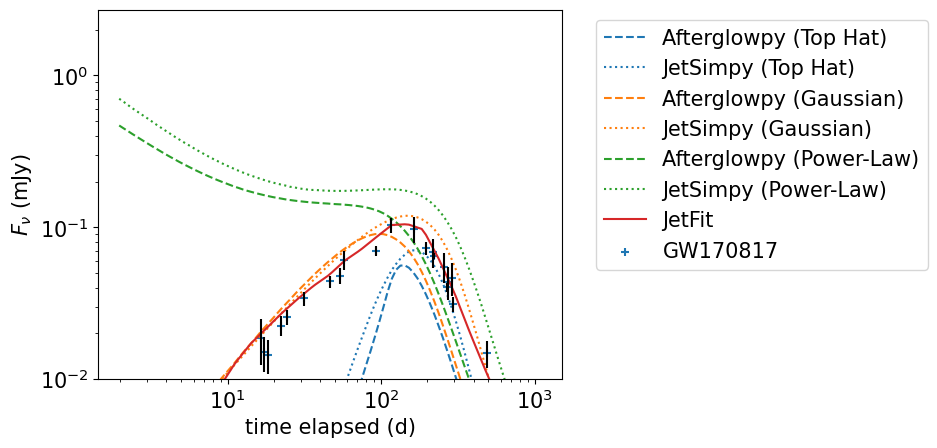

In [47]:
#To get a Label
Label = {
    r'$E_{iso}$': B['E'],
    r'$n$': B['n'],
    r'$\eta_0$': J['Eta0'],
    r'$\gamma_B$': J['GammaB'],
    r'$\theta_{obs}$': B['theta_obs'],
    r'$\epsilon_e$': B['epsilon_E'],
    r'$\epsilon_b$': B['epsilon_B']
}

labels = ["{}: {}".format(key, value) for key, value in Label.items()]


#Instructions for plotting the lightcurve

fig1, ax1 = plt.subplots(1, 1)

# Top Hat
#ax1.plot(convert_ts_td(tbox), Flbox, label="BoxFit") #convert_ts_td(tbox)
ax1.plot(convert_ts_td(tl), afterglowpys[0][0], label="Afterglowpy (Top Hat)", color = 'tab:blue', linestyle='dashed')
ax1.plot(convert_ts_td(tl), jetsimpys[0], label="JetSimpy (Top Hat)", color = 'tab:blue', linestyle='dotted') #convert_ts_td(tlj)

#Gaussian
ax1.plot(convert_ts_td(tl), afterglowpys[1][0], label="Afterglowpy (Gaussian)", color = 'tab:orange', linestyle='dashed')
ax1.plot(convert_ts_td(tl), jetsimpys[1], label="JetSimpy (Gaussian)", color = 'tab:orange', linestyle='dotted') #convert_ts_td(tlj) 

#Power-Law
ax1.plot(convert_ts_td(tl), afterglowpys[2][0], label="Afterglowpy (Power-Law)", color = 'tab:green', linestyle='dashed')
ax1.plot(convert_ts_td(tl), jetsimpys[2], label="JetSimpy (Power-Law)", color = 'tab:green', linestyle='dotted') #convert_ts_td(tlj)


#Boosted ireball (JetFit)
ax1.plot(convert_ts_td(tl), Fljet, label="JetFit", color = 'tab:red') #convert_ts_td(tlj) Fljet*1e-6


# Afterglowpy for every jet type
#[ax1.plot(convert_ts_td(tl), afterglowpys[i][0], label= f"Afterglowpy ({name_types_jets[i]})", linestyle='dashed') for i in range(3)] #convert_ts_td(tl) #len(afterglowpys)
#ax1.plot(convert_ts_td(tl), Fnula, label="Afterglowpy") #convert_ts_td(tl)


#Event data with its errorbars
ax1.scatter(t_gw, Fl_gw, label = "GW170817", marker = '+')
ax1.errorbar(t_gw, Fl_gw,yerr=Flerr_gw,linestyle='', color='black')

#DeepGlow
#ax1.plot(convert_ts_td(tl), Fldeep , label="DeepGlow")

#ax1.set_title("{}".format(",".join(labels)))
ax1.set(xscale='log', xlabel=r'time elapsed (d)',
       yscale='log', ylabel=r'$F_\nu$ (mJy)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_ylim(10**-2,)
plt.subplots_adjust(right=0.85)
fig1.savefig("lightcurve_comp.png", bbox_inches='tight')

fig1.show()

# #Instructions for plotting the spectrum

# fig2, ax2 = plt.subplots(1, 1)
# [ax2.plot(nus, afterglowpys[i][1], label= f"Afterglowpy ({name_types_jets[i]})", linestyle='dashed') for i in range(len(afterglowpys))] #convert_ts_td(tl)
# #ax2.plot(nus, Fnusa, label="Afterglowpy")
# ax2.plot(nus, Fnubox, label="BoxFit")
# ax2.plot(nusj, Fsjet, label="JetFit")
# ax2.set_title("Spectrum from different models")
# ax2.set(xscale='log', xlabel=r'$\nu$ (Hz)',
#        yscale='log', ylabel=r'$F_\nu$ (mJy)')
# ax2.legend()
# fig2.savefig("spectrum_comp.png")
#fig2.show()



### Table of the input of each model

This table indicates the input of each model with its units (or a . when there's no unit). 

| Input Parameter | BoxFit | Afterglowpy | JetFit | JetSimpy |
|:--------:|:--------:|:--------:| :--------:| :--------:|
|  $\theta_{obs}$   | . rad   | . rad  |   | . rad  |
|  $\theta_{j}$    | . rad   |  . rad  |   | . rad  |
|  $\theta_{wing}$    |    |  rad   |   |  |
|  $n$    | . $cm^{-3}$   | . $cm^{-3}$   | . $cm^{-3}$/1 $cm^{-3}$  | . $cm^{-3}$   |
|  $p$    |  .  |  .   | .   | .  |
|  $E$   |     |     | . erg / 10^50   |    |
|  $E_{iso}$   |  . erg   | . erg   |   | . erg   |
|  $\eta_0$   |     |    | .   |    |
|  $\gamma_B$    |     |    | .   |    |
|  $\Gamma$    |     |    |    | .  |
|  $\epsilon_B$   |  .  |  .   | .   | .  |
|  $\epsilon_E$   |  .   |  .  | .  | .  |
|  $\xi_N$   |  .  |  .   | .   |   |
|  $d_L$   |  cm   |  cm   | cm  | Mpc   |
|  $z$   |  .  |  .   | .   | .  |
|  $b$   |    |  .   |   | .  |

Table of the inputs of each model for generating the lightcurves above.

In [34]:
import pandas as pd

models = {
    "BoxFit": [B['theta_obs'], B['theta_0'], '', '', '', '', '', B['E'], B['n'], B['p'], '', B['epsilon_E'], B['epsilon_B'], B['ksi_N'], B['d_L'], B['z']],
    "Afterglowpy": [A['thetaObs'], A['thetaCore'], A['thetaWing'], '','', '', '', A['E0'], A['n0'], A['p'], A['b'], A['epsilon_e'], A['epsilon_B'], A['xi_N'], A['d_L'], A['z']],
    "JetFit": ['', '','', J['Eta0'], J['GammaB'], '', format(J['E'],'.2e'), '', J['n'], J['p'], '', J['epse'], J['epsb'], J['xiN'], J['dL'], J['z']],
    "JetSimpy": [JS['theta_v'], JS['theta_c'], '', '', '', JS['lf'], '', JS['Eiso'], JS['n0'], JS['p'], JS['b'], JS['eps_e'], JS['eps_b'], '', format(JS['d'],'.2e'), JS['z']]
}

# The format is the following:
# "Model": [D['thetaObs'], D['thetaCore'], D['thetaWing'], D['Eta0'], D['GammaB'], D['E'], D['Eiso'], D['n0'], D['p'], D['b'], D['epsilon_e'], D['epsilon_B'], D['xi_N'], D['d_L'], D['z']]

variables = ['theta_obs','theta_j', 'theta_wing', 'eta_0', 'gamma_B', 'lf', 'E', 'E_iso', 'n', 'p', 'b', 'eps_e', 'eps_b', 'xi_N', 'd_L', 'z']

variables_unit_B = [' rad', ' rad', '', '', '', '','', ' erg', ' cm^-3', '', '', '', '', '', ' cm', '']
variables_unit_A = [' rad', ' rad', ' rad', '', '', '','', ' erg', ' cm^-3', '', '', '', '', '', ' cm', '']
variables_unit_J = ['', '', '', '', '', '',' erg/10^50', '', '', '', '', '', '', '', ' cm/10^28', '']
variables_unit_JS = [' rad', ' rad', '', '', '', '', '',' erg', ' cm^-3', '', '', '', '', '', ' Mpc', '']

df = pd.DataFrame(models, variables)
df['BoxFit'] = df['BoxFit'].astype(str) + variables_unit_B
df['Afterglowpy'] = df['Afterglowpy'].astype(str) + variables_unit_A
df['JetFit'] = df['JetFit'].astype(str) + variables_unit_J
df['JetSimpy'] = df['JetSimpy'].astype(str) + variables_unit_JS

print(df)

                   BoxFit                 Afterglowpy              JetFit  \
theta_obs        0.44 rad                    0.44 rad                       
theta_j     0.0698132 rad               0.0698132 rad                       
theta_wing                                   0.88 rad                       
eta_0                                                                   8   
gamma_B                                                                12   
lf                                                                          
E                                                      2.50e+00 erg/10^50   
E_iso         8.2e+53 erg  1.0208249320351635e+53 erg                       
n              0.01 cm^-3                  0.01 cm^-3                0.01   
p                    2.15                        2.15                2.15   
b                                                 4.5                       
eps_e                 0.1                         0.1                 0.1   

### Attempt to verify that only the ratio $\theta_{obs}$/$\theta_j$ is constrained

In [35]:
def time_flux_peaks(Fnu, t):
    
    Fnu_peak = np.max(Fnu)
    t_peak = t[np.argmax(Fnu)]

    return Fnu_peak, t_peak

In [36]:
import random

print(np.random.uniform(1,10))
#Rescaling as in Nakar

def rescaling( theta_obs, theta_0,E, n, epse, nu, d_L,p, Fl, t, ): #maybe change this with **kwargs but beware that not all dictionnaries have the same key name for the same physical variable (or the same scale, check jetfit)

    #Get the old ratio, should be constrained between 10 and 3
    ratio = theta_obs/theta_0
    print('The ratio is', ratio)

    #Get the new angle values with the same ratio, theta_obs contrained between 0 and 1.57, theta_0 between 0.045 and 0.5, wrote a statement in case out of bounds
    theta_obs_re = np.random.uniform(0.045*ratio,1.57)
    theta_0_re = theta_obs_re/ratio

    if theta_0_re > 0.5 or theta_0_re < 0.045:
        print('Random theta j out of bounds for this ratio and theta obs', theta_0_re)

    #Get the previous t_peak and f_peak
    Fl_peak, t_peak = time_flux_peaks(Fl, t)

    #Get the new t_peak and F_peak
    n_re = (((theta_obs_re - theta_0_re)**2*E**(1/3))/t_peak)**(1/3)
    epsb_re = ((Fl_peak)/E*(n**(p+1/4))*(epse**(p-1))*(theta_obs**(-2*p))*(nu**(-(p-1)/2))*(d_L**-2))**(4/p+1)

    #Calculate the 
    return theta_obs_re, theta_0_re, epsb_re, n_re

6.304221897627295


In [37]:
rescaling(B['theta_obs'], B['theta_0'], B['E'], B['n'], B['epsilon_E'], nus[0], B['d_L'], B['p'], Flbox, tbox)

The ratio is 6.302533045326672


(0.47364460439144435, 0.0751514670347745, 0.0, 1977.1906784650475)

### Attempt to calculate the flux peak for every model

In [38]:
# Variables
E = B['E']
n = B['n']
p = B['p']
eps_e = B['epsilon_E']
eps_B = B['epsilon_B']
d = B['d_L']
nu = nul[0]
theta_obs = B['theta_0']

def flux_peak(F):
    actual_peak = np.amax(F)
    flux_peak = E*np.power(n,(p+1)/4)*np.power(eps_e,p-1)*np.power(eps_B,(p+1)/4)*np.power(theta_obs,-2*p)*np.power(nu,-(p-1)/2)*np.power(d,-2)
    constant = flux_peak/actual_peak
    return flux_peak, constant

#flux_peak, constant = flux_peak(Flbox)
#print(flux_peak, constant)

print(np.amax(Fljet))
abcdefg, hijklmn = flux_peak(Fljet)
#print(flux_peak_jet, constant_jet)
print(abcdefg, hijklmn)

0.10460664450890762
3.1094952779504923e-06 2.9725600056750773e-05


## Plotting E($\theta$) for every jet structure

In [39]:
def convert_deg_to_rad(deg):
    return deg*np.pi/180

In [40]:
def convert_rad_to_deg(rad):
    return rad*180/np.pi

In [41]:
convert_deg_to_rad(10)

0.17453292519943295

In [42]:
thetalinsp = np.linspace(0, 0.6981317007977318, 1000)

# Fetching the variables

theta_c = 0.0698132 # 10 degrees 0.17453292519943295
b = A['b']
E_iso = B['E']
gb = J['GammaB']
e0 = J['Eta0']
c = 3*10**8 #speed of light in vacuum 

# Top Hat
E_th = np.heaviside(-thetalinsp+theta_c,thetalinsp[999]- theta_c) # Using the heaviside funcion that is 0 for x < 0 and 1 for x > 1 with x running from 1 to -9 to get only a small potion that is = 1 with sharp edges

# Gaussian
E_g = np.exp(-0.5*(thetalinsp/theta_c)**2) 

# Power-Law
E_pl = ( 1 + (1/b)*(thetalinsp/theta_c)**2 )**(-b/2)

# Boosted Fireball
v0 = np.sqrt(1 - 1/e0**2)
vb = np.sqrt(1 - 1/gb**2) 
sin_fact = gb*vb*np.sin(thetalinsp)
gamma_max_0 = gb*(e0 + vb*e0*v0)
gamma_max = gb*(e0 + vb*np.cos(thetalinsp))*np.sqrt((e0*v0)**2 - sin_fact**2)/(1 + sin_fact**2)
E_bf = (gamma_max/gamma_max_0)**3


In [43]:
def normalize_E(E):
    return E/E[0]

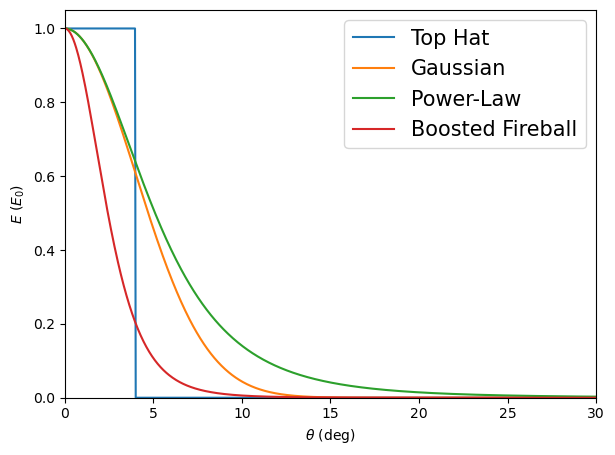

In [44]:
fig3, ax3 = plt.subplots(1, 1)
plt.rcParams.update({'font.size': 15})
ax3.plot(convert_rad_to_deg(thetalinsp), E_th, label="Top Hat")
ax3.plot(convert_rad_to_deg(thetalinsp), E_g, label="Gaussian") 
ax3.plot(convert_rad_to_deg(thetalinsp), E_pl, label="Power-Law") 
ax3.plot(convert_rad_to_deg(thetalinsp), normalize_E(E_bf), label="Boosted Fireball") 
ax3.set_xlim(0,30)
ax3.set_ylim(0,)
#ax3.set_title("Energy per angle of structured jets")
ax3.set(xlabel=r'$\theta$ (deg)', ylabel=r'$E$ ($E_0$)')
ax3.legend()
plt.tight_layout()
fig3.savefig("profiles.png")